# Введение в GCNN. Message passing framework

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Курс "Машинное обучение на графах", Лекции 4-5 "Графовые нейронные сети"
* Документация:
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.triangles.html
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.eccentricity.html#networkx.algorithms.distance_measures.eccentricity
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html

* Дополнительные источники:
    * https://tkipf.github.io/graph-convolutional-networks/

## Вопросы для совместного обсуждения

1\. Обсудите общие принципы организации вычислений в MPF и его использование для построения графовых сверточных нейронных сетей.

In [1]:
import torch as th

In [2]:
A = th.tensor(
    [
        [0, 1, 1],
        [1, 0, 1],
        [1, 0, 0]
    ],
    dtype=th.float32
)

X = th.tensor(
    [
      [1, 1],
      [2, 2],
      [3, 3],
    ],
    dtype=th.float32
)

In [3]:
A @ X

tensor([[5., 5.],
        [4., 4.],
        [1., 1.]])

In [4]:
W = th.rand(X.shape[1], 1)
A @ X @ W

tensor([[6.2526],
        [5.0021],
        [1.2505]])

## Задачи для самостоятельного решения

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import random

import torch as th
import torch.nn as nn
import torch.optim as optim

<p class="task" id="1"></p>

1\. Загрузите граф из файла `karate.graphml`. Визуализируйте граф, раскрасив в цвета классов (атрибут `label` у узлов).

Получите невзвешенную матрицу смежности $\mathbf{A}$ в виде тензора `torch` и тензор меток для каждого узла. Выведите полученные тензоры на экран.

- [ ] Проверено на семинаре

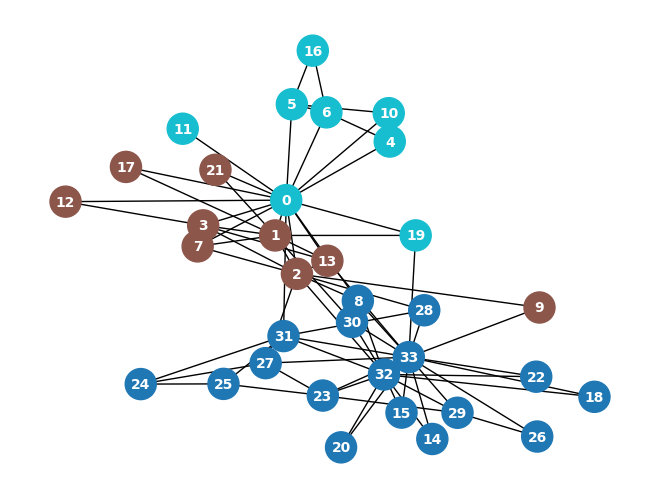

In [6]:
G = nx.read_graphml("data/karate.graphml")
labels = nx.get_node_attributes(G, 'label')
pos = nx.spring_layout(G, seed=0) 
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=labels.values(),
    cmap=plt.cm.tab10,
    font_color='white',
    font_size=10,
    font_weight='bold',
    node_size=500,
)

In [7]:
A = th.tensor(nx.to_numpy_array(G, weight=None, dtype=int),
               dtype=th.float32)

y = th.tensor(list(labels.values()), dtype=th.long)

A, y

(tensor([[0., 1., 1.,  ..., 1., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]),
 tensor([2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

<p class="task" id="2"></p>

2\. Найдите стохастическую матрицу $\hat{\mathbf{A}}$.

$$\hat{\mathbf{A}} =\mathbf{D}^{-1}\mathbf{A}$$


Сгенерируйте тензор $\mathbf{X}$ размера `Nx5` с признаками узлов, используя `torch.rand`. Выполните один шаг рассылки сообщений при помощи матричного умножения.

$$\hat{\mathbf{X}} =\hat{\mathbf{A}}\mathbf{X}$$

Выполните этот же шаг рассылки сообщений, явно проитерировавшись по узлам графа и усреднив атрибуты соседей. Сравните два полученных тензора и покажите, что они равны.

- [ ] Проверено на семинаре

In [8]:
X = th.rand(N:=len(G), 5)
D = th.diag(A.sum(axis=1))
A_stoch = th.linalg.inv(D) @ A
X_1 = A_stoch @ X

X_2 = th.zeros_like(X)
for i in range(N):
    X_2[i] = th.stack([X[int(n)] for n in G.neighbors(str(i))]).mean(dim=0)

th.allclose(X_1, X_2)

True

<p class="task" id="3"></p>

3\. Опишите слой `GCNLayer` графовой сверточной нейронной сети. Создайте слой с `n_outputs=3` и пропустите через этот слой матрицу смежности графа и тензор признаков  $\mathbf{X} = \mathbf{E}$. Выведите форму полученного тензора на экран.

- [ ] Проверено на семинаре

In [9]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, activation: Callable | None = None) -> None:
        super().__init__()

        # self.W - веса слоя
        W = th.empty(n_inputs, n_outputs, dtype=th.float32)
        nn.init.xavier_uniform_(W)
        self.W = nn.Parameter(W, requires_grad=True)

        # self.activation - функция активации, применяется после рассылки сообщений, может отсутствовать
        self.activation = activation

    def normalize_matrix(self, A: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа"""
        D = th.diag(A.sum(dim=1))
        return th.linalg.inv(D) @ A


    def forward(self, A: th.Tensor, X: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа
        X - матрица признаков узлов
        """
        A_norm = self.normalize_matrix(A)
        Z = A_norm @ X @ self.W
        return self.activation(Z) if self.activation is not None else Z

In [10]:
E = X.clone()
layer = GCNLayer(n_inputs=E.size(1), n_outputs=3, activation=nn.ReLU())
out = layer(A, E)
out.shape

torch.Size([34, 3])

<p class="task" id="4"></p>

4\. Используя графовую сверточную нейронную сеть, решите задачу классификации узлов. Создайте модель, состоящую из двух последовательно идущих слоев `GCNLayer`. Первый слой имеет 2 нейрона и гиперболический тангенс в качестве функции активации. Количество нейронов во втором слое определяется количеством классов в задаче. Настройте модель (в качестве признаков узлов используйте единичную матрицу $\mathbf{X} = \mathbf{E}$).

После завершения процесса обучения пропустите данные через первый слой и визуализируйте граф, используя полученные векторные представления в качестве координат. Раскрасьте узлы в цвет соответствующих классов.

- [ ] Проверено на семинаре

In [11]:
class GCNNet(nn.Module):
    def __init__(self, n_nodes, n_hidden, n_classes):
        super().__init__()
        self.gcn1 = GCNLayer(n_inputs=n_nodes, n_outputs=n_hidden, activation=nn.Tanh())
        self.gcn2 = GCNLayer(n_inputs=n_hidden, n_outputs=n_classes, activation=None)

    def forward(self, A, X):
        h = self.gcn1(A, X)   
        out = self.gcn2(A, h)  
        return out, h

model = GCNNet(n_nodes=N, n_hidden=2, n_classes=3)

optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

X = th.eye(N, dtype=th.float32)

model.train()
for epoch in range(301):
    optimizer.zero_grad()
    logits, _ = model(A, X)   
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Эпоха {epoch:03d} | loss = {loss.item():.4f}")

model.eval()
with th.no_grad():
    _, H = model(A, X)

Эпоха 000 | loss = 1.0919
Эпоха 050 | loss = 0.6951
Эпоха 100 | loss = 0.4174
Эпоха 150 | loss = 0.3041
Эпоха 200 | loss = 0.2411
Эпоха 250 | loss = 0.2017
Эпоха 300 | loss = 0.1736


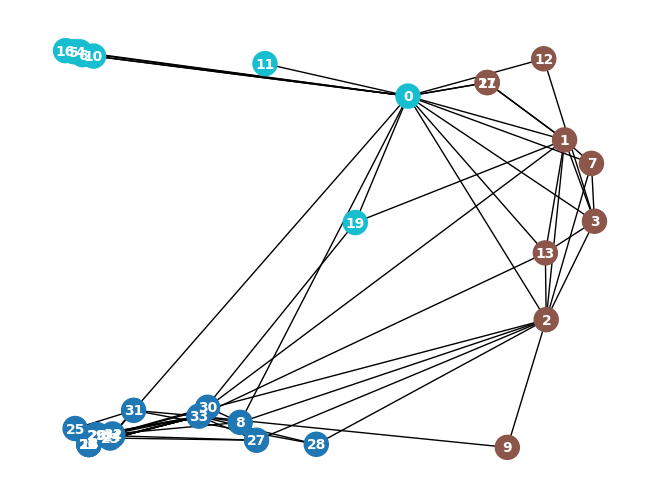

In [12]:
nodes = list(G.nodes())
pos = {nodes[i]: (H[i, 0].item(), H[i, 1].item()) for i in range(N)}
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=labels.values(),
    cmap=plt.cm.tab10,
    font_color='white',
    font_size=10,
    font_weight='bold',
    node_size=300,
)

<p class="task" id="5"></p>

5\. Повторите решение предыдущей задачи, используя в качестве признаков $\mathbf{X}$ следующие характеристики узлов (каждый узел описывается четырьмя характеристиками):
* количество треугольников, в которые входит узел;
* степень узла;
* эксцентриситет узла;
* центральность по собственному вектору для узла.

Для ускорения процесса обучения стандартизуйте тензор признаков.


- [ ] Проверено на семинаре

In [13]:
triangles_dict = nx.triangles(G)
triangles = np.array([triangles_dict[n] for n in nodes], dtype=np.float32)

degrees = np.array([d for _, d in G.degree(nodes)], dtype=np.float32)

eccentricity_dict = nx.eccentricity(G)
eccentricity = np.array([eccentricity_dict[n] for n in nodes], dtype=np.float32)

eig_dict = nx.eigenvector_centrality_numpy(G)
eig = np.array([eig_dict[n] for n in nodes], dtype=np.float32)

X = th.tensor(np.vstack([triangles, degrees, eccentricity, eig]).T, dtype=th.float32)
mean = X.mean(dim=0, keepdim=True)
std  = X.std(dim=0, unbiased=False, keepdim=True)
X = (X - mean) / std

In [19]:
model = GCNNet(n_nodes=X.size(1), n_hidden=2, n_classes=3)

optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(301):
    optimizer.zero_grad()
    logits, _ = model(A, X)   
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Эпоха {epoch:03d} | loss = {loss.item():.4f}")

model.eval()
with th.no_grad():
    _, H = model(A, X)

Эпоха 000 | loss = 1.2030
Эпоха 050 | loss = 1.0260
Эпоха 100 | loss = 0.7451
Эпоха 150 | loss = 0.4737
Эпоха 200 | loss = 0.3786
Эпоха 250 | loss = 0.3208
Эпоха 300 | loss = 0.2835


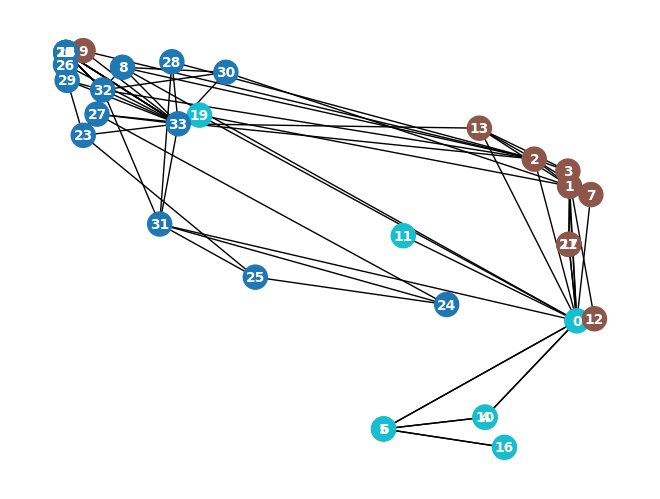

In [20]:
nodes = list(G.nodes())
pos = {nodes[i]: (H[i, 0].item(), H[i, 1].item()) for i in range(N)}
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=labels.values(),
    cmap=plt.cm.tab10,
    font_color='white',
    font_size=10,
    font_weight='bold',
    node_size=300,
)